<a href="https://colab.research.google.com/github/praveentecsl/High-Engagement-Content-Classification-model/blob/main/SocialMedia_engagement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**mount to drive**



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**MODEL**

=====================================================================================================

###Data Engineering & Preprocessing

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# 1. Load data
df = pd.read_csv('ad_campaign_data.csv')

# 2. Define Target (Industrial logic: use the median of the existing score)
# This creates a balanced classification problem
df['Is_High_Engagement'] = (df['engagement_duration'] > df['engagement_duration'].median()).astype(int)

# 3. Drop "Non-Predictive" and "Leakage" columns
# We drop IDs to prevent feature explosion and engagement_score to prevent the model from "cheating"
cols_to_drop = ['user_id', 'ad_id', 'interaction_timestamps', 'engagement_duration', 'Is_High_Engagement']
X = df.drop(columns=cols_to_drop)

# 4. Handle Categorical Columns (gender, location, device_type, ad_category)
X_final = pd.get_dummies(X, columns=['gender', 'location', 'device_type', 'ad_category'])

# 5. Define the Target variable (y)
y = df['Is_High_Engagement']

# 6. Professional Split: Train (70%), Validation (15%), and Test (15%)
# First, we separate the training set from the rest (30%)
# 'stratify=y' ensures each set has the same proportion of high/low engagement
X_train, X_temp, y_train, y_temp = train_test_split(
    X_final, y, test_size=0.30, random_state=42, stratify=y
)

# Second, we split the 30% into equal halves for Validation and Testing
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# 7. Scaling Module (Industrial Standard: Fit only on Train)
# We use the training set's statistics to scale ALL sets.
scaler = StandardScaler()

# Calculate mean/std AND transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform Val and Test data using the Training set's parameters
# (Never use .fit() on validation or test data!)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"--- Data Partitioning Complete ---")
print(f"Total Features: {X_final.shape[1]}")
print(f"Training Samples:   {X_train_scaled.shape[0]}")
print(f"Validation Samples: {X_val_scaled.shape[0]}")
print(f"Testing Samples:    {X_test_scaled.shape[0]}")

print(f"Cleaned Feature Count: {X_final.shape[1]}") # This should now be a small, healthy number

--- Data Partitioning Complete ---
Total Features: 42
Training Samples:   70000
Validation Samples: 15000
Testing Samples:    15000
Cleaned Feature Count: 42


###Find the best k

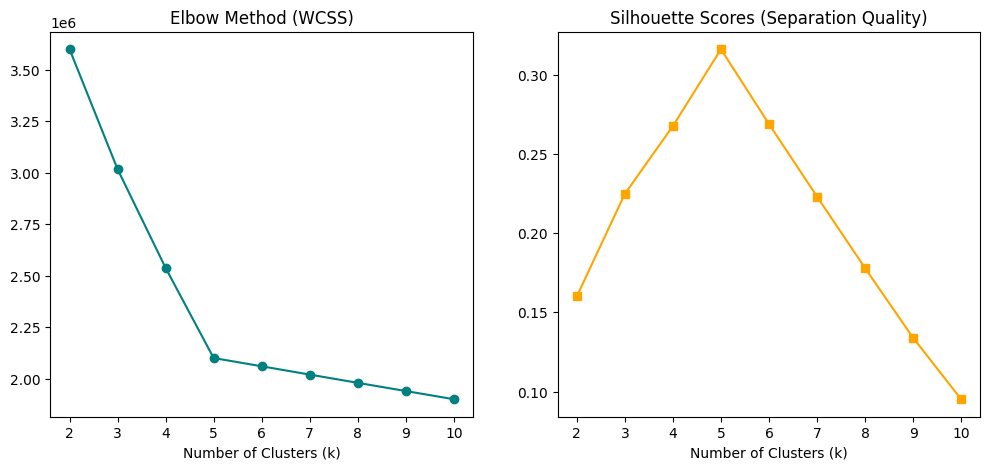

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

wcss = []
silhouette_avg = []
k_range = range(2, 11) # Silhouette requires at least 2 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_train_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_avg.append(silhouette_score(X_train_scaled, kmeans.labels_))

# Plotting the Elbow Method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), wcss, marker='o', color='teal')
plt.title('Elbow Method (WCSS)')
plt.xlabel('Number of Clusters (k)')

# Plotting Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_avg, marker='s', color='orange')
plt.title('Silhouette Scores (Separation Quality)')
plt.xlabel('Number of Clusters (k)')
plt.show()

==========================================================================================================

###Train the model

In [18]:
# Initialize and Fit the Model
optimal_k = 5
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
cluster_labels = kmeans_final.fit_predict(X_train_scaled)

# Add the predictions back to your original dataframe for business analysis
#df['Predicted_Engagement_Tier'] = cluster_labels

In [12]:
print(np.unique(cluster_labels))
print(np.bincount(cluster_labels))


[0 1 2 3 4]
[13347 40066 20169  6558 19860]


###centroids to 2D plane

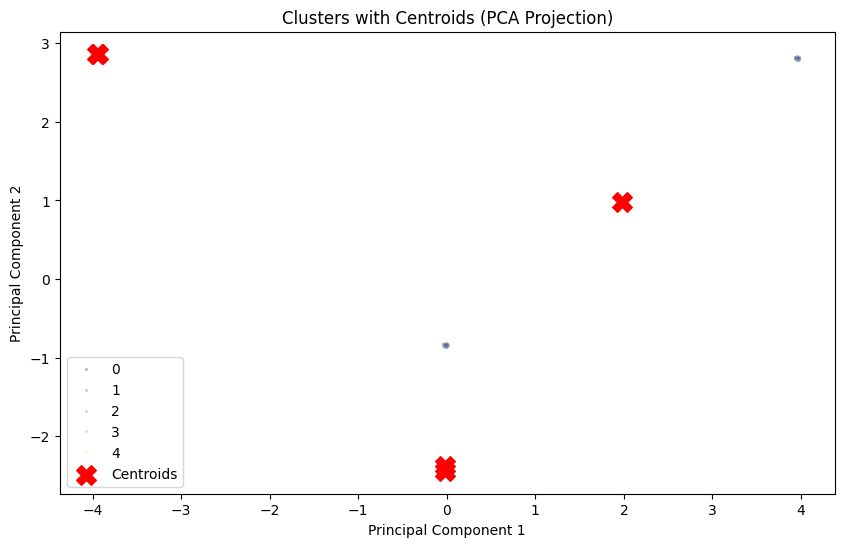

In [13]:
# Get centroids in original space
centroids = kmeans_final.cluster_centers_

# Project centroids into PCA space
centroids_pca = pca.transform(centroids)

# Plot points + centroids
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=5, alpha=0.3)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, marker='X', label='Centroids')
plt.title('Clusters with Centroids (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


###performance and working ability

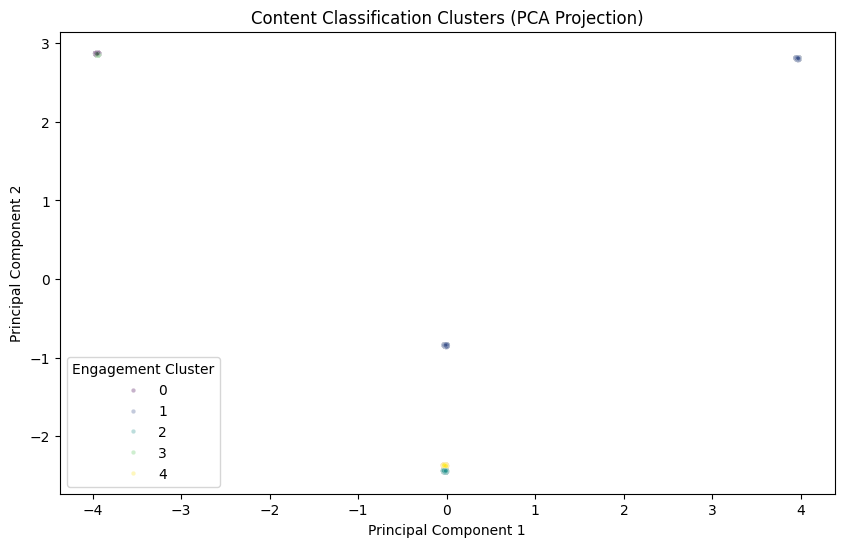

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=cluster_labels,
    palette='viridis',
    s=10,       # smaller point size
    alpha=0.3   # transparency so overlaps are visible
)

plt.title('Content Classification Clusters (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Engagement Cluster')
plt.show()

In [14]:
# Get the average values of the 42 features for each cluster
centroids = pd.DataFrame(scaler.inverse_transform(kmeans_final.cluster_centers_), columns=X_final.columns)

# Look at the top 5 differentiating features
diff = (centroids.iloc[1] - centroids.iloc[0]).sort_values(ascending=False)
print("Top Drivers for High Engagement:")
print(diff.head(5))

Top Drivers for High Engagement:
device_type_0    0.330754
tfidf_3          0.288358
tfidf_6          0.288358
tfidf_18         0.288358
tfidf_2          0.223852
dtype: float64


#**********git configuration**********

##setup and pull

In [4]:
# --- SECTION 1: SETUP & SYNC ---
import os
from google.colab import drive, userdata

# 1. Mount Google Drive
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("drive already mounted")

# 2. Configuration (Ensure 'GITHUB_TOKEN' is in your Colab Secrets 🔑)
GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')
GITHUB_USER = "praveentecsl"
REPO_NAME = "High-Engagement-Content-Classification-model"
# Navigate to where you want to store the project in Drive
PROJECT_PATH = f"/content/drive/MyDrive/{REPO_NAME}"

# 3. Clone or Pull Logic
if not os.path.exists(PROJECT_PATH):
    # If the folder doesn't exist, go to Drive root and clone
    %cd /content/drive/MyDrive/
    !git clone https://{GITHUB_TOKEN}@github.com/{GITHUB_USER}/{REPO_NAME}.git
    %cd {REPO_NAME}
    print("✅ Repository Cloned for the first time.")
else:
    # If folder exists, go inside and pull latest changes from collaborator
    %cd {PROJECT_PATH}
    !git pull origin main
    print("✅ Repository updated with latest changes (Git Pull).")

# 4. Identity Configuration for Commits
!git config --global user.email "your-email@example.com"
!git config --global user.name "Praveen"

drive already mounted
/content/drive/MyDrive/High-Engagement-Content-Classification-model
From https://github.com/praveentecsl/High-Engagement-Content-Classification-model
 * branch            main       -> FETCH_HEAD
   7938465..0aa00c8  main       -> origin/main
Already up to date.
✅ Repository updated with latest changes (Git Pull).


##push code

In [5]:
!pwd

/content/drive/MyDrive/High-Engagement-Content-Classification-model


In [ ]:
!git status


On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   SocialMedia_engagement.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
#@title 🚀 Git Push Interface
#@markdown Enter your message in the box on the right, then run this cell.

# 1. Capture the input from the form into a variable
Commit_Message = "add data preprocessing part " #@param {type:"string"}

import os

# 2. Ensure we are in the Repo directory
%cd {PROJECT_PATH}

# 3. Git Workflow
print(f"--- Processing: {Commit_Message} ---")

# Add all changes
!git add .

# Commit using the variable from the form
# We use the '$' prefix to pass the Python variable into the shell command
!git commit -m "{Commit_Message}"

# Push to GitHub
!git push https://{GITHUB_TOKEN}@github.com/{GITHUB_USER}/{REPO_NAME}.git main

print(f"\n✅ Successfully pushed to GitHub with message: {Commit_Message}")

/content/drive/MyDrive/High-Engagement-Content-Classification-model
--- Processing: add data preprocessing part  ---
[main 7938465] add data preprocessing part
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite SocialMedia_engagement.ipynb (93%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.40 KiB | 95.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/praveentecsl/High-Engagement-Content-Classification-model.git
   0371433..7938465  main -> main

✅ Successfully pushed to GitHub with message: add data preprocessing part 
